## Data `Distributions`, `Training Percentiles` & `Normalising`

* The aim of this notebook is to look at widening the image distributions to help improve the model training. Each NxN image has a lot of 0 pixels so we want to apply a reversible (linear) transformation that can widen the distribution, accentuate the features whilst keeping the rainfall intensities apparent. I.e. we can't just clip the images to `[0, 1]` as we will lost the areas of high intensity as it will all blend to 1.

* Based on the above, the aim of this dataset is to read in the i, j boxes and get the percentiles from the training data for linear log normalisation 

* This notebook used the datamodule used in DYffusion.

* This medium article was helpful for the log linear norm eq: https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af 

In [1]:
from typing import Union, Dict

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path
import seaborn as sns
import numpy as np
import dask
from scipy import io
import xarray as xr
from skimage import exposure

from rainnow.src.configs.data_processing_configs import sequencing_config
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.plotting import plot_sequence
from rainnow.src.configs.config import PATCH_SIZE
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


#### `helpers.`

In [ ]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"

# load in custom colour map.
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}
global_params = {"font.size": 12}

#### `instantiate the dataloaders + get batch of data`

In [3]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "normalization": None,  # set normalisation to None. Need raw data to analyse.
        # "boxes": ["0,0"],
        "boxes": ["1,0"],
        # "boxes": ["2,0"],
        # "boxes": ["2,1"],
        # "boxes": ["0,0", "1,0", "2,0", "2,1"],
    },
)

In [4]:
datamodule.hparams

"batch_size":         6
"box_size":           128
"boxes":              ['1,0']
"data_dir":           /teamspace/studios/this_studio/data/imerg-precipitation
"data_splits":        {'train': [None, '2023-01-01 00:00:00'], 'val': ['2023-01-01 00:00:00', '2023-07-01 00:00:00'], 'test': ['2023-07-01 00:00:00', '2024-01-01 00:00:00'], 'predict': ['2023-03-07 00:00:00', '2023-03-10 00:00:00']}
"drop_last":          False
"eval_batch_size":    6
"horizon":            8
"multi_horizon":      False
"normalization":      None
"num_workers":        4
"persistent_workers": False
"pin_memory":         True
"prediction_horizon": 8
"seed_data":          43
"sequence_dt":        1
"verbose":            True
"window":             1

In [5]:
datamodule.setup("fit")
# datamodule.setup("validate")
# datamodule.setup("test")

[2024-08-30 06:29:28][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-30 06:29:28][imerg_precipitation.py][INFO] --> train data split: [None, 202301010000]


[2024-08-30 06:29:29][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-30 06:29:29][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-30 06:32:23][torch_datasets.py][INFO] --> creating TRAIN tensor dataset.
[2024-08-30 06:32:54][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-08-30 06:32:54][abstract_datamodule.py][INFO] -->  Dataset sizes train: 4817, val: 873


In [6]:
Xtrain = datamodule.get_ds_xarray("train", datamodule.train_slice)
Xtrain.data

[2024-08-30 06:32:54][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-30 06:32:54][imerg_precipitation.py][INFO] --> train data split: [None, 202301010000]


dask.array<where, shape=(4817, 9, 128, 128), dtype=float64, chunksize=(4817, 9, 128, 128), chunktype=numpy.ndarray>

In [7]:
# convert it to numpy for easier plotting.
data = Xtrain.to_numpy()
data.shape

(4817, 9, 128, 128)

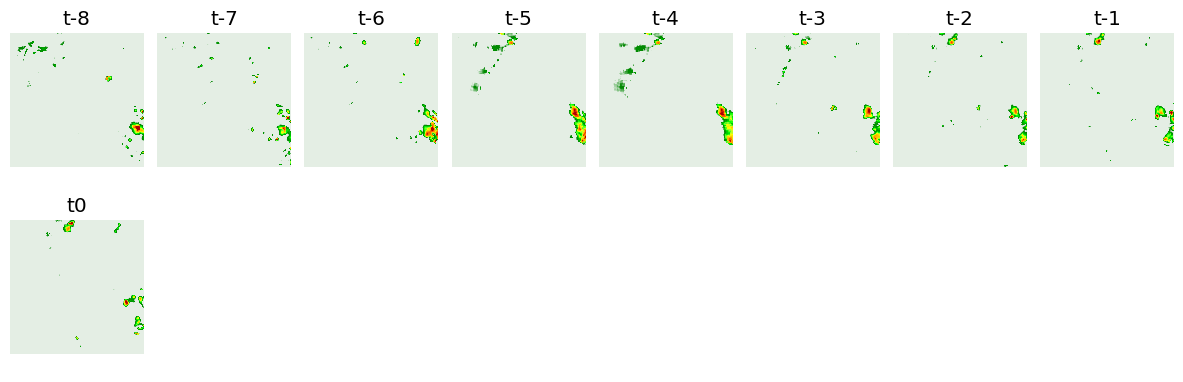

In [8]:
# plot raw sequences.
idx = 3000
plot_sequence(
    idx=idx,
    data=data,
    sequence_length=data.shape[1] - 1,
    horizon=1,
    global_params=global_params,
    plot_params=plot_params,
    figsize=(12, 4),
)

#### `plotting random raw distribution`

min pixel val = 0.0, max pixel value = 28.65999984741211


<Axes: ylabel='Density'>

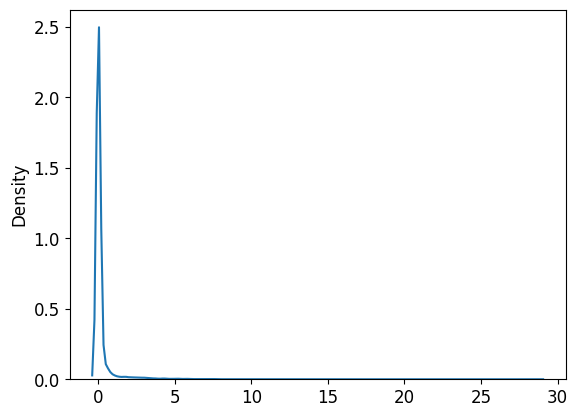

In [9]:
# using X_train lets plot some of the raw distributions.
idx = 200
s = 3
_to_plot = data[idx][s, :, :]
print(f"min pixel val = {_to_plot.min()}, max pixel value = {_to_plot.max()}")
sns.kdeplot(_to_plot.flatten())

* Distributions are very narrow.

* There are a lot of 0 pixel

* Even though we ensure that only sequences with avg 1mm/h of rain are included the distributions are still narrow

* Taking the 1st and 99th percentiles and then applying a linear transform of the data can help to widen the distribution and shorten the range. 

* Also apply log(data = 1) to again try and widen the distribution 

#### `get 1st and 99th percentiles of the training data`

In [10]:
# percentiles
p1, p99 = np.percentile(data.flatten(), [1, 99])
print(f"percentiles: 1st = {p1}, 99th {p99}")

percentiles: 1st = 0.0, 99th 5.509999752044678


In [11]:
# raw data min and max
raw_data_min, raw_data_max = np.min(data), np.max(data)
print(f"raw min, max: ({raw_data_min}, {raw_data_max})")

raw min, max: (0.0, 115.72999572753906)


In [12]:
# raw data min and max
raw_data_mu, raw_data_std = np.mean(data), np.std(data)
print(f"raw mu, std: ({raw_data_mu}, {raw_data_std})")

raw mu, std: (0.26702688495047855, 1.2072827721779227)


In [13]:
preprocesser = PreProcess()

[2024-08-30 06:33:11][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): None,  (min, max): None


In [14]:
log_lin_transform_training_data = preprocesser.log_linear_norm(data=data, c=p1, d=p99, a=0, b=1)

#### `get min and max of the linear transformed training data`

In [15]:
# get the min and max of the log linear transformed training data.
data_min = np.min(log_lin_transform_training_data.flatten())
data_max = np.max(log_lin_transform_training_data.flatten())
print(f"min, max: ({data_min}, {data_max})")

# # get the mu and std of the log linear transformed training data.
# data_mu = np.mean(log_lin_transform_training_data.flatten())
# data_std = np.std(log_lin_transform_training_data.flatten())
# print(f"mu, std: ({data_mu}, {data_std})")

min, max: (0.0, 3.091207436740887)


In [16]:
# create a new preprocessor object for the training p1, p99 and min and max
preprocesser = PreProcess(percentiles=[p1, p99], minmax=[data_min, data_max])

[2024-08-30 06:33:17][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.509999752044678],  (min, max): [0.0, 3.091207436740887]


In [17]:
# undersample the data to have less (speed it up...)
print(f"*** RAW data shape: {data.shape} ***")
jump = 4
data = data[::jump, :, :, :]
print(f"*** UNDERSAMPLED data shape: {data.shape} ***")

*** RAW data shape: (4817, 9, 128, 128) ***
*** UNDERSAMPLED data shape: (1205, 9, 128, 128) ***


In [18]:
processed_data = preprocesser.apply_preprocessing(data=data)

In [19]:
# reverse the transform and make sure it equals the raw data.
reversed_data = preprocesser.reverse_processing(data=processed_data)
assert np.allclose(data, reversed_data)

#### `exploring the effects of the data processing`

Text(0.5, 1.0, 'processed 2 element of 22 sequence.')

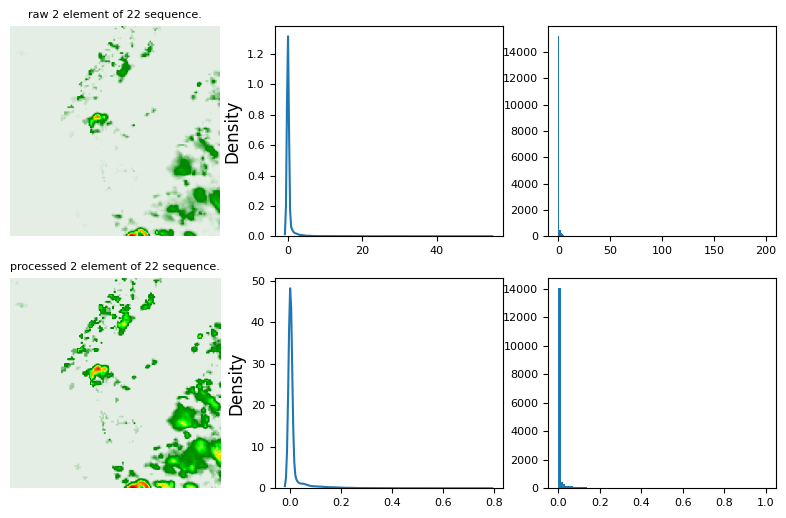

In [20]:
# plot a raw and a processed data sequence element.
idx = 22
s = 2

plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
cmap = rain_cmap

axs[0, 0].imshow(data[idx, s, :, :], cmap=cmap)
axs[0, 0].axis("off")
sns.kdeplot(data[idx, s, :, :].flatten(), ax=axs[0, 1])
axs[0, 2].hist(data[idx, s, :, :].flatten(), bins=np.arange(0, 200 + 0.1, 1))
axs[0, 0].set_title(f"raw {s} element of {idx} sequence.", fontsize=8)

axs[1, 0].imshow(processed_data[idx, s, :, :], cmap=cmap)
axs[1, 0].axis("off")
sns.kdeplot(processed_data[idx, s, :, :].flatten(), ax=axs[1, 1])
axs[1, 2].hist(processed_data[idx, s, :, :].flatten(), bins=np.arange(0, 1 + 0.01, 0.01))
axs[1, 0].set_title(f"processed {s} element of {idx} sequence.", fontsize=8)

* distribution is definitely wider and the range [0,1] is much more desirable for training.
* the image still has a lot of zeroes
* the rain features are definitely enhanced after processing.

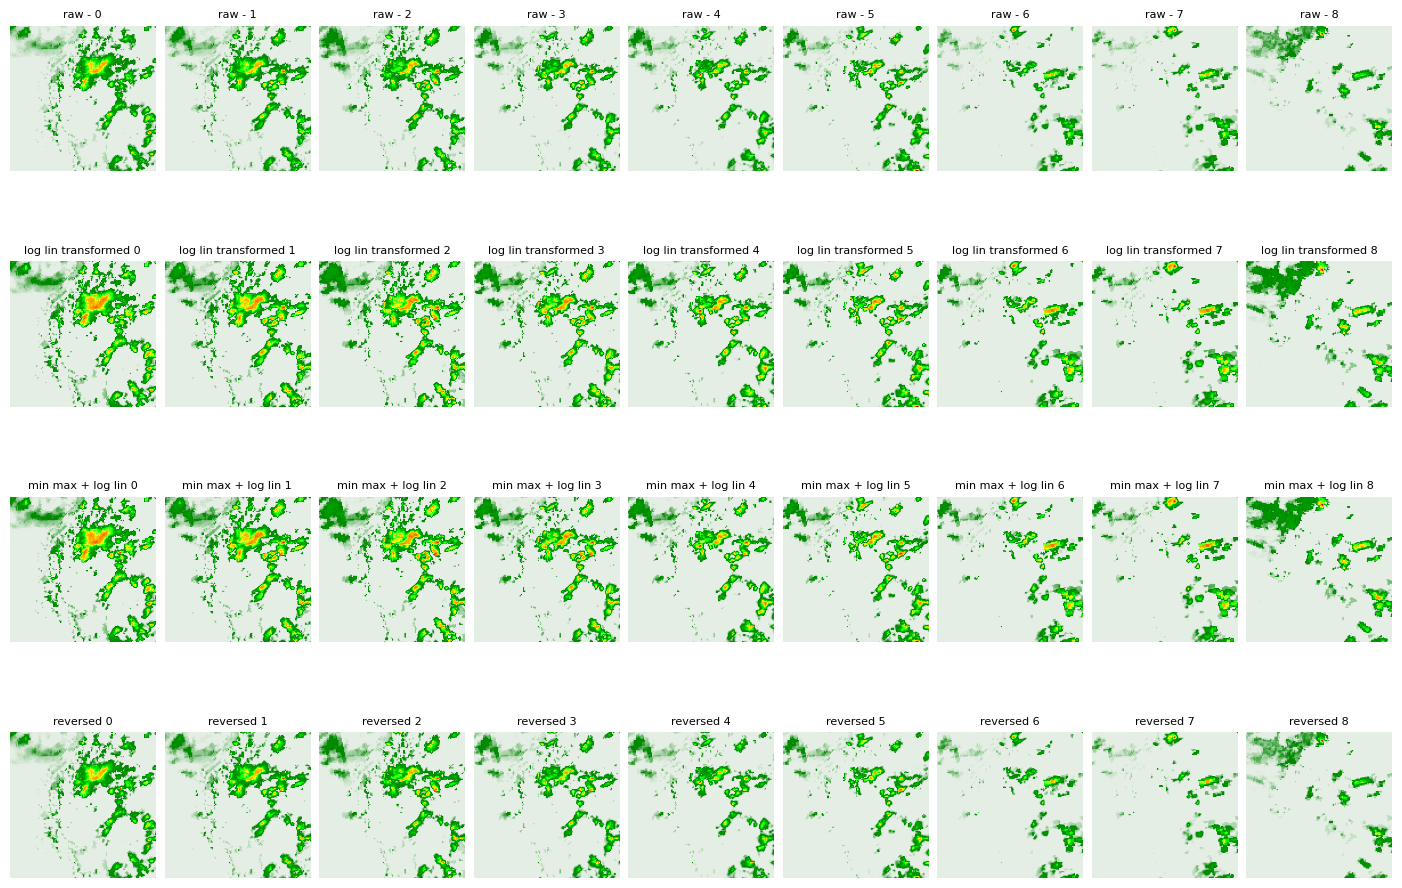

In [29]:
# plot raw, lin norm, max_lin_norm sequence + reversed.
fig, axs = plt.subplots(4, data.shape[1], figsize=(14, 10))
idx = 11
cmap = rain_cmap
for i in range(data.shape[1]):

    data_to_plot = data[idx, i, :, :]

    axs[0, i].imshow(data_to_plot, cmap=cmap)
    axs[0, i].set_title(f"raw - {i}", fontsize=8)
    axs[0, i].axis("off")

    axs[1, i].imshow(preprocesser.log_linear_norm(data=data_to_plot, c=p1, d=p99, a=0, b=1), cmap=cmap)
    axs[1, i].set_title(f"log lin transformed {i}", fontsize=8)
    axs[1, i].axis("off")

    axs[2, i].imshow(processed_data[idx, i, :, :], cmap=cmap)
    axs[2, i].set_title(f"min max + log lin {i}", fontsize=8)
    axs[2, i].axis("off")

    _reversed = preprocesser.reverse_processing(processed_data[idx, i, :, :])
    assert np.allclose(data_to_plot, _reversed)
    axs[3, i].imshow(preprocesser.reverse_processing(processed_data[idx, i, :, :]), cmap=cmap)
    axs[3, i].set_title(f"reversed {i}", fontsize=8)
    axs[3, i].axis("off")

plt.tight_layout()

#### `plotting some random sequences...`

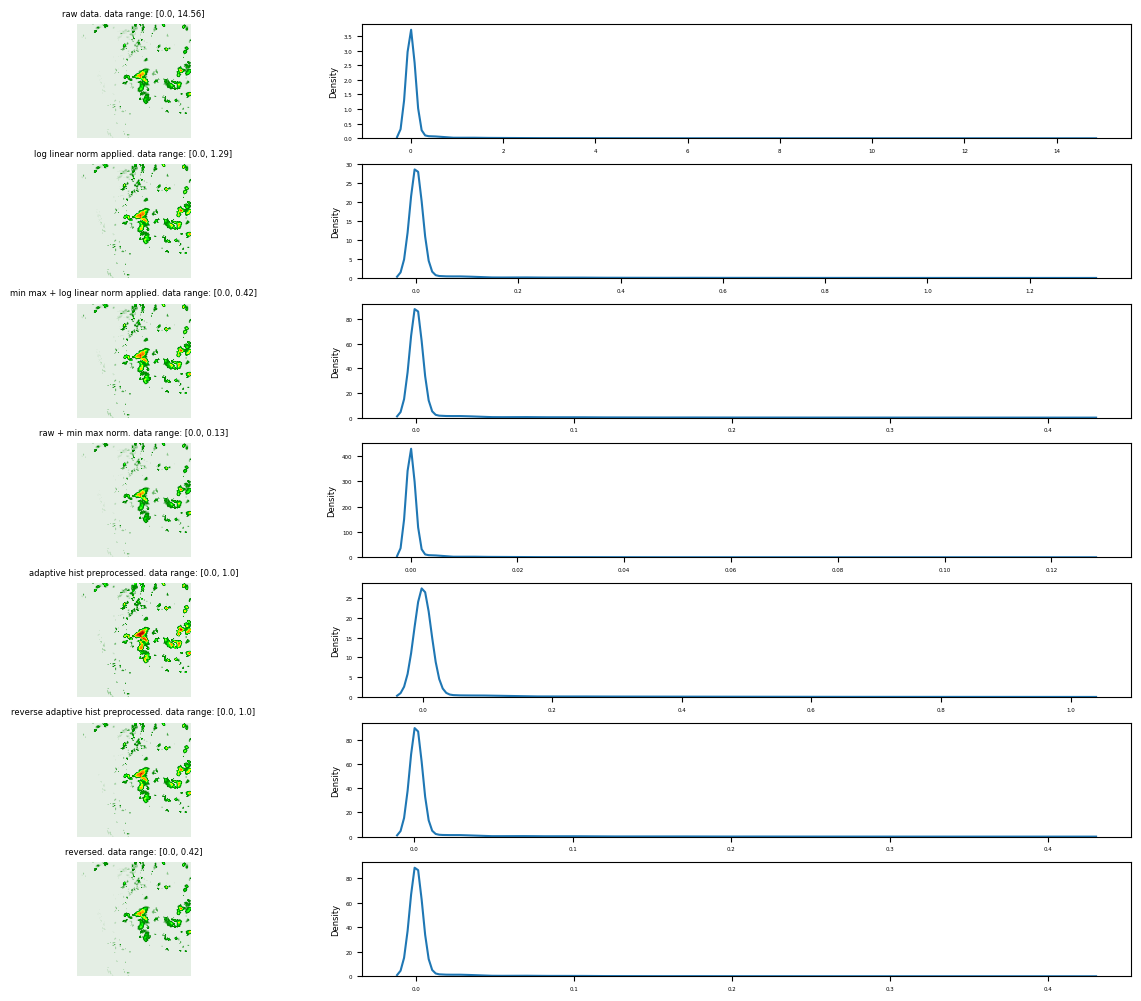

In [27]:
# lets plot some raw versus normed kde and normal plots
num_seq = 200
seq_idx = 3

# cmap = "viridis"
cmap = rain_cmap

fig, axs = plt.subplots(7, 2, figsize=(14, 10))
global_params.update({"xtick.labelsize": 4, "ytick.labelsize": 4, "axes.titlesize": 6, "font.size": 6})
plt.rcParams.update(global_params)  # Update global parameters.

# [1] raw data.
axs[0, 0].imshow(data[num_seq, s, :, :], cmap=cmap)
axs[0, 0].set_title(
    f"raw data. data range: [{round(data[num_seq, s, :, :].min(),2)}, {round(data[num_seq, s, :, :].max(),2)}]"
)
sns.kdeplot(data[num_seq, s, :, :].flatten(), ax=axs[0, 1])
axs[0, 0].axis("off")

# [2] log lin norm.
data_lln = preprocesser.log_linear_norm(
    data=data[num_seq, s, :, :],
    c=preprocesser.percentiles[0],
    d=preprocesser.percentiles[1],
    a=0,
    b=1,
)
axs[1, 0].imshow(data_lln, cmap=cmap)
axs[1, 0].set_title(
    f"log linear norm applied. data range: [{round(data_lln.min(),2)}, {round(data_lln.max(),2)}]"
)
sns.kdeplot(data_lln.flatten(), ax=axs[1, 1])
axs[1, 0].axis("off")

# [3] min max + log linear norm
data_mm_lln = preprocesser.apply_preprocessing(data[num_seq, s, :, :])
data_mm_lln_chk = preprocesser.min_max_norm(
    data=preprocesser.log_linear_norm(
        data=data[num_seq, s, :, :],
        c=preprocesser.percentiles[0],
        d=preprocesser.percentiles[1],
        a=0,
        b=1,
    ),
    _min=preprocesser.minmax[0],
    _max=preprocesser.minmax[1],
)
assert np.allclose(data_mm_lln, data_mm_lln_chk)
axs[2, 0].imshow(data_mm_lln, cmap=cmap)
axs[2, 0].set_title(
    f"min max + log linear norm applied. data range: [{round(data_mm_lln.min(),2)}, {round(data_mm_lln.max(),2)}]",
)
sns.kdeplot(data_mm_lln.flatten(), ax=axs[2, 1])
axs[2, 0].axis("off")

# [4] min max to the data (no linear transform)
data_mm = preprocesser.min_max_norm(data=data[num_seq, s, :, :], _min=raw_data_min, _max=raw_data_max)
axs[3, 0].imshow(data_mm, cmap=cmap)
axs[3, 0].set_title(
    f"raw + min max norm. data range: [{round(data_mm.min(),2)}, {round(data_mm.max(),2)}]"
)
sns.kdeplot(data_mm.flatten(), ax=axs[3, 1])
axs[3, 0].axis("off")

# [5] adaptive histogram (irreversible)
# apply the adaptive histogram to the fully transformed data.
data_eq = exposure.equalize_adapthist(data_mm_lln)
axs[4, 0].imshow(data_eq, cmap=cmap)
axs[4, 0].set_title(
    f"adaptive hist preprocessed. data range: [{round(data_eq.min(),2)}, {round(data_eq.max(),2)}]"
)
sns.kdeplot(data_eq.flatten(), ax=axs[4, 1])
axs[4, 0].axis("off")

# [6] reversed adaptive hist (~ approximate)
from skimage import exposure

data_eq_reversed = exposure.match_histograms(data_eq, data_mm_lln)
# data_eq_reversed = exposure.rescale_intensity(data_eq, out_range=(data_mm_lln.min(), data_mm_lln.max()))
axs[5, 0].imshow(data_eq_reversed, cmap=cmap)
axs[5, 0].set_title(
    f"reverse adaptive hist preprocessed. data range: [{round(data_eq.min(), 2)}, {round(data_eq.max(), 2)}]"
)
sns.kdeplot(data_eq_reversed.flatten(), ax=axs[5, 1])
axs[5, 0].axis("off")

# [7] fully reversed data. Reversing preprocess.apply_processing()
reversed = preprocesser.reverse_processing(data_mm_lln)
assert np.allclose(data[num_seq, s, :, :], reversed)
axs[6, 0].imshow(reversed, cmap=cmap)
axs[6, 0].set_title(
    f"reversed. data range: [{round(data_mm_lln.min(), 2)}, {round(data_mm_lln.max(), 2)}]",
)
sns.kdeplot(data_mm_lln.flatten(), ax=axs[6, 1])
axs[6, 0].axis("off")

plt.tight_layout()

### Comments:

* The normalisation it reversable which is important. 

* It is clear that the middle image has much more detail than the raw images due to widening the distribution. The scale is also much closer to [0,1] which will help the model training.

* Looking at some of the images, it might be worth increasing the pavg_pixel threshold as some images don't have much information / rain in them.

* Adaptive hist does massively improve the distribution but it does add a lot more detail. 

* Definitely worth trying the adaptive hist but the definite is that I will apply `min max log linear norm` on the raw imerg data.

### END OF SCRIPT.